In [6]:
import sys
import time
import math
import glob
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

# =========================
# GLOBAL CONFIG (KEEP HERE)
# =========================

# CPU only
device = torch.device("cpu")

# Paths
models_dir = Path("models")

# Seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# "Deep Yellow" sigmoid-anneal schedule (same as your working script)
ANNEAL_T_START = 5.0
ANNEAL_STEPS   = 100
ANNEAL_FALLOFF = 0.4
T_END          = 1.0

# Evaluation / sampling
TOTAL_SAMPLES = 300_000
CHUNK_SIZE    = 10_000

# h-grid
DENSE_RES = 0.05

print(f"Running on: {device}")

Running on: cpu


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(
            x,
            [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden],
            dim=-1
        )


class ConditionalRBM(nn.Module):
    def __init__(
            self,
            num_visible: int,
            num_hidden: int,
            cond_dim: int,
            conditioner_width: int = 64,
            k: int = 1,
            T: float = 1.0
    ):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

        nn.init.normal_(self.W, std=0.01)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    @staticmethod
    def _apply_flip(v: torch.Tensor, s0: torch.Tensor) -> torch.Tensor:
        return s0 * v + (1.0 - s0) * (1.0 - v)

    def _gibbs_step_sym_fast(self, v, h, s0, b_mod, c_mod, rng):
        # 1) sample h | v,s
        v_eff = self._apply_flip(v, s0)
        p_h = torch.sigmoid((v_eff @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)

        # 2) sample s | v,h
        a = h @ self.W.t()
        vb   = (v * b_mod).sum(dim=-1)
        va   = (v * a).sum(dim=-1)
        bsum = b_mod.sum(dim=-1)
        asum = a.sum(dim=-1)
        dE = (-bsum - asum + 2.0 * vb + 2.0 * va)
        p_s0 = torch.sigmoid(dE / self.T)
        s0 = torch.bernoulli(p_s0, generator=rng).to(v.dtype).unsqueeze(-1)

        # 3) sample v | h,s
        p_v = torch.sigmoid((a + b_mod) / self.T)
        v_eff = torch.bernoulli(p_v, generator=rng)
        v_next = self._apply_flip(v_eff, s0)
        return v_next, h, s0

    # --- Free energy / scoring ---
    def _free_energies_pair(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor):
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_f = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_f).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)
        return (term1_v - term2_v), (term1_f - term2_f)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        F_v, F_f = self._free_energies_pair(v, b_mod, c_mod)
        stacked = torch.stack([-F_v, -F_f], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    # --- Sigmoid annealed generation (same as your working script) ---
    @torch.no_grad()
    def generate_sigmoid(self, cond: torch.Tensor, steps: int, falloff: float, rng: torch.Generator) -> torch.Tensor:
        if cond.dim() == 1:
            cond = cond.view(-1, 1)
        cond = cond.to(self.W.device, dtype=self.W.dtype)

        b_mod, c_mod = self._compute_effective_biases(cond)
        B = cond.shape[0]

        v = torch.bernoulli(
            torch.full((B, self.num_visible), 0.5, device=self.W.device, dtype=self.W.dtype),
            generator=rng
        )
        h = torch.zeros((B, self.num_hidden), device=self.W.device, dtype=self.W.dtype)
        s0 = torch.ones((B, 1), device=self.W.device, dtype=self.W.dtype)

        t_indices = torch.arange(steps, device=self.W.device, dtype=self.W.dtype)
        center = steps / 2.0
        s = 1.0 / (1.0 + torch.exp(falloff * (t_indices - center)))
        temps = T_END + (ANNEAL_T_START - T_END) * s

        T_original = float(self.T)
        for i in range(steps):
            self.T = temps[i]
            v, h, s0 = self._gibbs_step_sym_fast(v, h, s0, b_mod, c_mod, rng)

        self.T = T_original
        return v


In [3]:
def compute_renyi_large_batch(
        samples: torch.Tensor,
        subs_size: int,
        log_score_fn: callable,
        chunk_size: int = 10_000
) -> tuple:
    n_total = samples.shape[0]
    n_chunks = max(1, n_total // chunk_size)
    scores = log_score_fn(samples)

    chunk_s2_values = []
    for i in range(n_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, n_total)
        if end - start < 2:
            continue

        c_samples = samples[start:end]
        c_scores = scores[start:end]
        half = (end - start) // 2
        if half < 1:
            continue

        ref_1 = c_samples[:half]
        ref_2 = c_samples[half:2 * half]
        ref_1_score = c_scores[:half]
        ref_2_score = c_scores[half:2 * half]

        slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)
        swap_1 = ref_1.clone()
        swap_1[:, slice_idx] = ref_2[:, slice_idx]
        swap_2 = ref_2.clone()
        swap_2[:, slice_idx] = ref_1[:, slice_idx]

        log_ratios = (log_score_fn(swap_1) + log_score_fn(swap_2)) - (ref_1_score + ref_2_score)
        max_val = torch.max(log_ratios)
        log_mean = (torch.log(torch.sum(torch.exp(log_ratios - max_val))) + max_val) - math.log(half)
        chunk_s2_values.append(-log_mean.item())

    vals = np.array(chunk_s2_values)
    mean = float(np.mean(vals)) if len(vals) else float("nan")
    err = float(np.std(vals, ddof=1) / np.sqrt(len(vals))) if len(vals) > 1 else 0.0
    return mean, err


def load_latest_model():
    search_path = models_dir / "crbm_tfim_16_*.pt"
    files = glob.glob(str(search_path))
    if not files:
        raise FileNotFoundError("No models found!")

    latest_file = max(files, key=os.path.getctime)
    print(f"Loading latest model: {latest_file}")

    checkpoint = torch.load(latest_file, map_location=device)
    cfg = checkpoint.get("config", {})

    model = ConditionalRBM(
        num_visible=cfg.get("num_visible", 16),
        num_hidden=cfg.get("num_hidden", 64),
        cond_dim=1,
        conditioner_width=64,
        k=cfg.get("k_steps", 20),
        T=1.0
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, cfg


model, config = load_latest_model()
CHAIN_LENGTH = model.num_visible
h_support_vals = sorted(config.get("h_support", [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]))
print(f"Loaded L={CHAIN_LENGTH}. Support: {h_support_vals}")


Loading latest model: models/crbm_tfim_16_20000_entropy_20260113_172434.pt
Loaded L=16. Support: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]


In [4]:
# Grid setup
h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, DENSE_RES)
h_novel_vals = [h for h in h_novel_vals if not any(np.isclose(h, s, atol=1e-3) for s in h_support_vals)]
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

results_list = []
l_axis = list(range(1, CHAIN_LENGTH // 2 + 1))

rng_eval = torch.Generator(device="cpu").manual_seed(SEED)
model_dtype = next(model.parameters()).dtype

print(f"\n=== Running Final Paper Evaluation ===")
print(f"Schedule: T={ANNEAL_T_START}->{T_END} | Steps={ANNEAL_STEPS} | falloff={ANNEAL_FALLOFF}")
print(f"TOTAL_SAMPLES={TOTAL_SAMPLES} | CHUNK_SIZE={CHUNK_SIZE}")

for i, h_val in enumerate(all_h_values):
    pt_type = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "interpolated"

    # 1) Generate with sigmoid anneal
    cond_gen = torch.tensor([[h_val]], device=device, dtype=model_dtype).expand(TOTAL_SAMPLES, -1)
    with torch.no_grad():
        samples = model.generate_sigmoid(cond_gen, ANNEAL_STEPS, ANNEAL_FALLOFF, rng_eval)

    # 2) Score closure
    cond_score = torch.tensor([[h_val]], device=device, dtype=model_dtype)
    scorer = lambda v: model.log_score(v, cond_score)

    # 3) Renyi S2
    for l in l_axis:
        s2_mean, s2_err = compute_renyi_large_batch(samples, l, scorer, chunk_size=CHUNK_SIZE)
        results_list.append({"h": float(h_val), "l": int(l), "s2": s2_mean, "s2_err": s2_err, "type": pt_type})

    if (i + 1) % 5 == 0 or (i + 1) == len(all_h_values):
        print(f"[{i+1}/{len(all_h_values)}] h={h_val:.2f} done.")

df_res = pd.DataFrame(results_list)
print("Done.")


=== Running Final Paper Evaluation ===
Schedule: T=5.0->1.0 | Steps=100 | falloff=0.4
TOTAL_SAMPLES=300000 | CHUNK_SIZE=10000
[5/21] h=0.70 done.
[10/21] h=0.95 done.
[15/21] h=1.20 done.
[20/21] h=1.45 done.
[21/21] h=1.50 done.
Done.


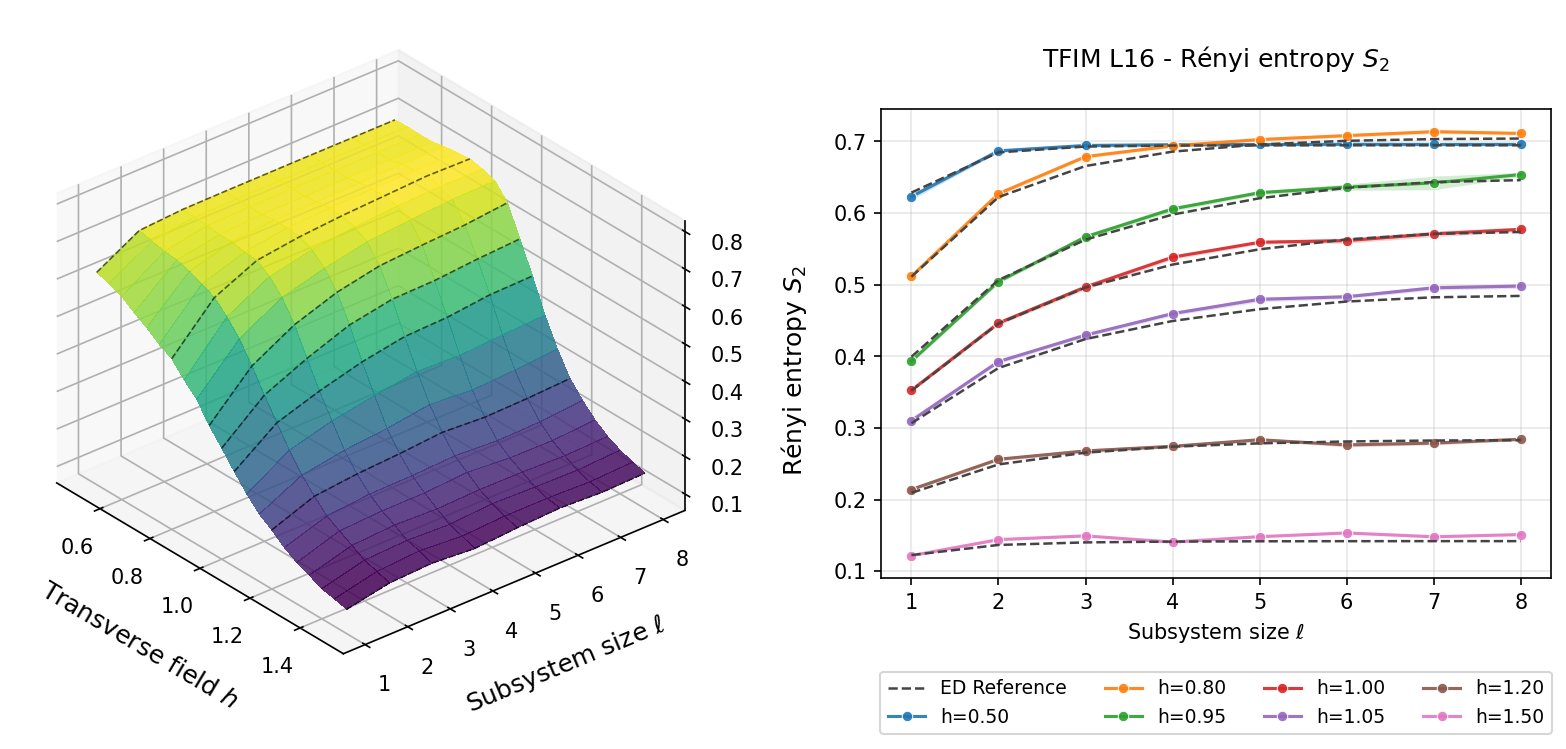

In [7]:
# CONFIGURATION (plot only)
PLOT_WSPACE = -0.15
VERTICAL_OFFSET_2D = 0.02
BOX_ASPECT_2D = 0.7
Z_LABEL_PAD = 9
TITLE_PAD_2D = 20
LEGEND_NCOL = 4
LEGEND_X = 0.5
LEGEND_Y = -0.18

# --- surface render safety caps (prevents "runs forever") ---
MAX_SURF_COLS = 220   # max columns along h rendered
MAX_SURF_ROWS = 80    # max rows along l rendered
SURF_SHADE    = False # True can be slow on CPU

# ----- data prep (IMPORTANT: sort + float) -----
pivot_df = df_res.pivot(index='l', columns='h', values='s2')
pivot_df = pivot_df.sort_index().sort_index(axis=1)

h_dense  = pivot_df.columns.to_numpy(dtype=float)
l_values = pivot_df.index.to_numpy(dtype=float)

X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.to_numpy(dtype=float)  # <-- critical: no object dtype

support_h_keys = sorted(df_res[df_res['type'] == 'support']['h'].unique())

fig = plt.figure(figsize=(16, 6), dpi=150)
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# --- 3D ---
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho')

# decimate if needed (keeps render fast)
step_c = max(1, X_h.shape[1] // MAX_SURF_COLS)
step_r = max(1, X_h.shape[0] // MAX_SURF_ROWS)

Xr = X_h[::step_r, ::step_c]
Yr = Y_l[::step_r, ::step_c]
Zr = Z_s2[::step_r, ::step_c]

surf = ax3d.plot_surface(
    Xr, Yr, Zr,
    cmap='viridis',
    rstride=1, cstride=1,
    shade=SURF_SHADE,
    linewidth=0,
    antialiased=False,
    alpha=0.85
)

ax3d.set_zlim(np.nanmin(Zr) - 0.05, np.nanmax(Zr) + 0.1)

ax3d.set_xlabel("Transverse field $h$", fontsize=12, labelpad=10)
ax3d.set_ylabel("Subsystem size $\\ell$", fontsize=12, labelpad=10)
ax3d.set_zlabel("Rényi entropy $S_2$", fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)

# Add lines on 3D (support h)
for h in support_h_keys:
    subset = df_res[df_res['h'] == h].sort_values('l')
    ax3d.plot(
        np.full_like(l_values, float(h), dtype=float),
        l_values,
        subset['s2'].to_numpy(dtype=float),
        color='black', linestyle='--', linewidth=0.8, alpha=0.6, zorder=10
    )

# --- 2D ---
ax2d = fig.add_subplot(gs[1])
ax2d.set_box_aspect(BOX_ASPECT_2D)
pos = ax2d.get_position()
ax2d.set_position([pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height])

cmap_2d = plt.get_cmap("tab10")

# Load ED ref (optional)
ref_df = None
try:
    ref_file = Path(f"tfim_{CHAIN_LENGTH}_entangle_ref.csv")
    if ref_file.exists():
        ref_df = pd.read_csv(ref_file)
except Exception:
    ref_df = None

ref_lbl_added = False

for i, h in enumerate(support_h_keys):
    subset = df_res[df_res['h'] == h].sort_values('l')
    s2 = subset['s2'].to_numpy(dtype=float)
    err = subset['s2_err'].to_numpy(dtype=float)
    col = cmap_2d(i % 10)

    # ED ref
    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-3)
        if mask.any():
            l_cols = sorted(
                [c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                key=lambda s: int(s[1:])
            )
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values.astype(float)
            x_ref = [int(c[1:]) for c in l_cols]
            lbl = "ED Reference" if not ref_lbl_added else "_nolegend_"
            ax2d.plot(x_ref, y_ref, '--', color='#444444', linewidth=1.2, label=lbl, zorder=5)
            ref_lbl_added = True

    ax2d.plot(
        l_values, s2, 'o-',
        color=col, markersize=5, linewidth=1.5, alpha=0.9,
        markeredgecolor='white', markeredgewidth=0.5,
        label=f"h={h:.2f}", zorder=4
    )
    ax2d.fill_between(l_values, s2 - err, s2 + err, color=col, alpha=0.2, linewidth=0)

ax2d.set_xlabel("Subsystem size $\\ell$")
ax2d.set_title(f"TFIM L{CHAIN_LENGTH} - Rényi entropy $S_2$", pad=TITLE_PAD_2D)
ax2d.legend(frameon=True, fontsize=9, loc='upper center',
            bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, alpha=0.3)

plt.show()


In [9]:
timestamp = time.strftime("%Y%m%d_%H%M%S")
save_path = Path(f"tfim_{CHAIN_LENGTH}_entangle_rbm_{timestamp}.csv")

df_res.to_csv(save_path, index=False)

print(f"Results saved successfully to: {save_path}")
print(f"Rows: {len(df_res)}")

Results saved successfully to: tfim_16_entangle_rbm_20260113_173945.csv
Rows: 168
